In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # For date formatting on plots
import os
import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score


# --- Constants ---
TOTAL_UNITS_TO_SELL_PER_DAY = 10
GBDT_PREDICTION_HORIZON_MINUTES = 5 # Predict price 5 minutes ahead
GBDT_TARGET_COLUMN = f'target_price_ratio_h{GBDT_PREDICTION_HORIZON_MINUTES}'
GBDT_FEATURE_COLUMNS = ['SMA_short', 'SMA_long', 'RSI', 'ROC', 
                        'Volatility', 'Momentum', 'Upper_Bollinger', 'Lower_Bollinger']
# !!! SET THIS TO A VALID TRADING DAY FROM YOUR DATASET !!!
DETAILED_TEST_DAY_STR = '2025-04-15' # Example: Make sure this date exists in your dataset


# --- 1. Data Loading and Preparation ---
def load_hsi_data(file_path="dataset/HSI_min_20250201-20250430.xlsx"):
    """Loads HSI data from Excel and sets datetime index."""
    hsi_df = pd.read_excel(file_path, index_col="index")
    hsi_df['datetime'] = pd.to_datetime(hsi_df['date'] + ' ' + hsi_df['time'])
    hsi_df = hsi_df.set_index('datetime')

    if 'close' in hsi_df.columns:
        hsi_df['close'] = pd.to_numeric(hsi_df['close'], errors='coerce')
        if hsi_df['close'].isnull().all():
            print("Warning: 'close' column is all NaNs after loading and pd.to_numeric(errors='coerce'). Check Excel file.")
    else:
        print("Warning: 'close' column not found. Feature calculation will likely fail.")
        hsi_df['close'] = np.nan 
    return hsi_df

hsi_df = load_hsi_data()


In [10]:
# --- 2. Feature Engineering ---
def add_features(df, sma_short_window=5, sma_long_window=20, rsi_window=14, roc_window=10):
    df_feat = df.copy()

    if 'close' not in df_feat.columns or df_feat['close'].dtype == 'object':
        df_feat.loc[:, 'close'] = pd.to_numeric(df_feat['close'], errors='coerce')

    if df_feat['close'].isnull().all():
        print("Warning in add_features: 'close' column is all NaNs. Feature values will be based on fillna logic.")

    df_feat.loc[:, 'SMA_short'] = df_feat['close'].rolling(window=sma_short_window, min_periods=1).mean()
    df_feat.loc[:, 'SMA_long'] = df_feat['close'].rolling(window=sma_long_window, min_periods=1).mean()

    # Momentum
    df_feat['Momentum'] = df_feat['close'] - df_feat['close'].shift(4)

    # Volume-Weighted Features (if volume data exists)
    if 'volume' in df_feat.columns:
        df_feat['VWAP'] = (df_feat['volume'] * df_feat['close']).cumsum() / df_feat['volume'].cumsum()

    delta = df_feat['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=rsi_window, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=rsi_window, min_periods=1).mean()
    
    rs = gain / loss.replace(0, 0.000001) # Avoid division by zero
    df_feat.loc[:, 'RSI'] = 100 - (100 / (1 + rs))

    df_feat.loc[:, 'ROC'] = df_feat['close'].pct_change(periods=roc_window) * 100 
    df_feat.loc[:, 'Volatility'] = df_feat['close'].pct_change().rolling(window=sma_long_window, min_periods=1).std() * np.sqrt(sma_long_window)
    df_feat.loc[:, 'Price_Pred_Simple'] = df_feat['close'].shift(1) + (df_feat['close'].shift(1) - df_feat['close'].shift(2))
    df_feat.loc[:, GBDT_TARGET_COLUMN] = df_feat['close'].shift(-GBDT_PREDICTION_HORIZON_MINUTES) / df_feat['close']
    
    # Bollinger Bands
    df_feat['Upper_Bollinger'] = df_feat['SMA_long'] + 2*df_feat['Volatility']
    df_feat['Lower_Bollinger'] = df_feat['SMA_long'] - 2*df_feat['Volatility']

    cols_to_process = GBDT_FEATURE_COLUMNS + ['Price_Pred_Simple', GBDT_TARGET_COLUMN]
    for col in cols_to_process:
        if col in df_feat.columns: # Check if column was actually created
            df_feat.loc[:, col] = pd.to_numeric(df_feat[col], errors='coerce')

    df_feat.replace([np.inf, -np.inf], np.nan, inplace=True) # inplace=True on the whole df_feat is fine here
    
    if 'RSI' in df_feat.columns:
        df_feat.loc[:, 'RSI'] = df_feat['RSI'].fillna(50) # Specific fill for RSI

    df_feat = df_feat.bfill().ffill() # df.bfill() preferred over fillna(method='bfill')
    return df_feat

featured_data_full = add_features(hsi_df)
featured_data_full.head()

,business date,date,time,open,high,low,close,turnover,SMA_short,SMA_long,Momentum,RSI,ROC,Volatility,Price_Pred_Simple,target_price_ratio_h5,Upper_Bollinger,Lower_Bollinger
datetime,,,,,,,,,,,,,,,,,,
2025-02-03 09:30:00,2025-02-03,2025-02-03,09:30:00,20048.87,20048.87,20048.87,20048.87,210367186,20048.87,20048.87,-34.59,0.00,-0.97,0.02,20201.89,1.00,20090.78,20090.72
2025-02-03 09:31:00,2025-02-03,2025-02-03,09:31:00,20040.03,20125.38,20040.03,20125.38,233333295,20087.12,20087.12,-34.59,100.00,-0.97,0.02,20201.89,0.99,20090.78,20090.72
2025-02-03 09:32:00,2025-02-03,2025-02-03,09:32:00,20120.99,20129.47,20098.00,20098.00,85137616,20090.75,20090.75,-34.59,73.65,-0.97,0.02,20201.89,0.99,20090.78,20090.72
2025-02-03 09:33:00,2025-02-03,2025-02-03,09:33:00,20097.95,20097.95,19996.73,20040.94,101702443,20078.30,20078.30,-34.59,47.54,-0.97,0.02,20070.62,0.99,20078.33,20078.27
2025-02-03 09:34:00,2025-02-03,2025-02-03,09:34:00,20039.30,20039.30,20005.90,20014.28,66246961,20065.49,20065.49,-34.59,40.78,-0.97,0.01,19983.88,0.99,20065.52,20065.47


In [11]:
def get_tradeable_data(df_daily_features):
    """Filters the DataFrame to include only tradeable minutes for a single day."""
    morning_trade_start = datetime.time(9, 45)
    morning_trade_end = datetime.time(11, 44, 59) 
    afternoon_trade_start = datetime.time(13, 15)
    afternoon_trade_end = datetime.time(15, 44, 59)

    times = df_daily_features.index.time
    is_in_morning_tradeable = (times >= morning_trade_start) & (times <= morning_trade_end)
    is_in_afternoon_tradeable = (times >= afternoon_trade_start) & (times <= afternoon_trade_end)
    tradeable_mask = is_in_morning_tradeable | is_in_afternoon_tradeable
    return df_daily_features[tradeable_mask]


def execute_trades(df_tradeable_day_period, total_units_to_sell, 
                   algo_logic_func, algo_name="Algo", gbdt_model=None):
    trades = []
    units_remaining = float(total_units_to_sell) # Ensure units_remaining is float
    cash_accumulated = 0.0
    
    if df_tradeable_day_period.empty:
        # print(f"Warning: No tradeable data for {algo_name} on this day.")
        return pd.DataFrame(trades), cash_accumulated

    acc_sell_cache_momentum = 0.0
    for i in range(len(df_tradeable_day_period)):
        if units_remaining <= 1e-9: # Using a small epsilon for float comparison
            break
        
        current_time = df_tradeable_day_period.index[i]
        current_price = df_tradeable_day_period['close'].iloc[i]
        current_features_row = df_tradeable_day_period.iloc[i]
        steps_left = len(df_tradeable_day_period) - 1 - i

        nominal_units_to_sell_decision = 0.0
        if steps_left == 0:
            # Last trading opportunity in the defined tradeable period for the algo, sell all remaining.
            # This can be a fractional amount.
            raw_algo_decision = units_remaining
        else:
            # Algorithmic decision for how much to ideally sell (can be float)
            if algo_name == "GBDTStrategy": # Requires GBDT_FEATURE_COLUMNS to be globally defined
                 raw_algo_decision = algo_logic_func(current_features_row, units_remaining, steps_left, gbdt_model)
            elif algo_name == "EvenSpreadSell":
                raw_algo_decision = algo_logic_func(current_features_row, units_remaining, steps_left, 
                                                    len(df_tradeable_day_period))
            else:
                raw_algo_decision = algo_logic_func(current_features_row, units_remaining, steps_left)
        
        nominal_units_to_sell_decision = raw_algo_decision
        acc_sell_cache_momentum += nominal_units_to_sell_decision

        if acc_sell_cache_momentum >= 1:
            acc_sell_cache_momentum = 0
        elif acc_sell_cache_momentum > 0.5:
            nominal_units_to_sell_decision = 1
            acc_sell_cache_momentum = 0
        else:
            continue

        # Cap the decision by available units and ensure it's not negative. This value is still float.
        capped_units_to_sell_float = max(0.0, min(nominal_units_to_sell_decision, units_remaining))

        # For algorithmic steps (not the final step in the loop), convert to integer.
        # The final step (steps_left == 0) sells the exact (potentially fractional) remaining amount.
        if steps_left == 0:
            units_to_sell_this_step = capped_units_to_sell_float 
        else:
            # Per requirement, units_to_sell_this_step must be an integer for algo-driven steps.
            units_to_sell_this_step = float(capped_units_to_sell_float) 
        
        if units_to_sell_this_step > 1e-9: # Sell if more than a tiny fraction (effectively > 0 for integers)
            trades.append({
                'timestamp': current_time, 
                'units_sold': int(units_to_sell_this_step), # Store as float in trades list
                'close': current_price, 
                'value': float(units_to_sell_this_step) * current_price
            })
            units_remaining -= float(units_to_sell_this_step)
            cash_accumulated += float(units_to_sell_this_step) * current_price
            units_remaining = max(0.0, units_remaining) # Ensure units_remaining doesn't go negative
    
    # If any units remain after the loop, force sell them at the last available price.
    # This handles fractions left over from int conversions or if algo didn't sell all.
    if units_remaining > 1e-9 and not df_tradeable_day_period.empty:
        last_price = df_tradeable_day_period['close'].iloc[-1]
        # print(f"INFO: {algo_name} force selling {units_remaining:.2f} units at EOD.")
        trades.append({
            'timestamp': df_tradeable_day_period.index[-1], 
            'units_sold': units_remaining, # Sell the exact fractional amount remaining
            'close': last_price, 
            'value': units_remaining * last_price
        })
        cash_accumulated += units_remaining * last_price
        units_remaining = 0.0 
        
    return pd.DataFrame(trades), cash_accumulated

In [12]:

def even_spread_one_unit_logic(current_features_row, units_left, steps_left,
                            total_timestamp_for_period: int,
                            initial_units_target_for_period: int = TOTAL_UNITS_TO_SELL_PER_DAY,):
    if steps_left == 0:
        return units_left
    if units_left <= 1e-9:
        return 0.0
    # Calculate the interval step based on the total timestamp and the initial units target
    interval_step = total_timestamp_for_period / initial_units_target_for_period
    # Calculate the current position within the period
    current_position = total_timestamp_for_period - steps_left
    # Check if current_position is at an interval step (considering floating point precision)
    if abs(current_position % interval_step) < 1e-9 or abs(interval_step - (current_position % interval_step)) < 1e-9:
        return 1.0
    else:
        return 0.0

def twap_logic(current_features_row, units_left, steps_left):
    if steps_left == 0: return units_left
    if units_left <= 1e-9: return 0.0 
    return units_left / (steps_left + 1) 

def moving_average_logic(current_features_row, units_left, steps_left, aggression=0.5):
    if steps_left == 0: return units_left
    if units_left <= 1e-9: return 0.0
    base_sell_amount = units_left / (steps_left + 1)
    price, sma_long = current_features_row['close'], current_features_row['SMA_long']
    if pd.isna(sma_long) or sma_long == 0: return base_sell_amount 
    if price > sma_long: return base_sell_amount * (1 + aggression) 
    elif price < sma_long: return base_sell_amount * (1 - aggression)
    return base_sell_amount

def momentum_logic(current_features_row, units_left, steps_left, aggression=0.5, roc_threshold=0.05):
    if steps_left == 0: return units_left
    if units_left <= 1e-9: return 0.0
    base_sell_amount = units_left / (steps_left + 1)
    roc = current_features_row['ROC']
    if pd.isna(roc): return base_sell_amount
    if roc < -roc_threshold: return base_sell_amount * (1 + aggression) # Negative ROC (price falling) -> sell more
    elif roc > roc_threshold: return base_sell_amount * (1 - aggression) # Positive ROC (price rising) -> sell less
    return base_sell_amount

def lstm_proxy_logic(current_features_row, units_left, steps_left, aggression=0.5):
    if steps_left == 0: return units_left
    if units_left <= 1e-9: return 0.0
    base_sell_amount = units_left / (steps_left + 1)
    current_price, predicted_price = current_features_row['close'], current_features_row['Price_Pred_Simple']
    if pd.isna(predicted_price) or pd.isna(current_price): return base_sell_amount
    # If predicted price is lower than current, means price expected to drop, so sell more
    if predicted_price < current_price: return base_sell_amount * (1 + aggression)
    # If predicted price is higher, means price expected to rise, so sell less
    elif predicted_price > current_price: return base_sell_amount * (1 - aggression)
    return base_sell_amount

# --- GBDT Strategy Logic (Modified for new target interpretation) ---
def gbdt_strategy_logic(current_features_row, units_left, steps_left, model, 
                        aggression=0.5, prediction_change_threshold=0.0005): # Uses global GBDT_FEATURE_COLUMNS
    if steps_left == 0: return units_left
    if units_left <= 1e-9: return 0.0
    if model is None: 
        if (steps_left + 1) == 0: return units_left # Avoid division by zero, though unlikely with steps_left == 0 check
        return units_left / (steps_left + 1) 
    
    base_sell_amount = units_left / (steps_left + 1)
    
    # Uses global GBDT_FEATURE_COLUMNS
    features_for_prediction_series = current_features_row[GBDT_FEATURE_COLUMNS]
    model_input_df = pd.DataFrame([features_for_prediction_series.values], columns=GBDT_FEATURE_COLUMNS)
    
    if model_input_df.isnull().values.any(): 
        # print("Warning: NaN found in features for GBDT prediction, using base sell amount.")
        return base_sell_amount 
    
    predicted_max_future_price = model.predict(model_input_df)[0]
    current_price = current_features_row['close']

    if pd.isna(predicted_max_future_price) or pd.isna(current_price) or current_price == 0:
        # print("Warning: NaN in prediction or current price, or current price is zero. Using base sell amount.")
        return base_sell_amount

    adjustment_factor = 0.0
    # If predicted max future price is significantly higher than current price, sell LESS (negative adjustment).
    if predicted_max_future_price > current_price * (1 + prediction_change_threshold):
        adjustment_factor = -aggression 
    # If predicted max future price is significantly lower than current price, sell MORE (positive adjustment).
    elif predicted_max_future_price < current_price * (1 - prediction_change_threshold):
        adjustment_factor = +aggression
    # Else: (predicted price is close to current price, or model is unsure)
    # Default behavior is base_sell_amount (adjustment_factor = 0.0).
    
    return max(0.0, base_sell_amount * (1 + adjustment_factor)) # Ensure not negative


In [13]:


# --- Assumed Global Constants (User needs to define/update these) ---
# Example:
# GBDT_FEATURE_COLUMNS = ['feature1', 'volume_change', 'RSI', 'SMA_short_diff'] 
# GBDT_LOOKAHEAD_MINUTES = 10 
# GBDT_TARGET_COLUMN = f'max_price_next_{GBDT_LOOKAHEAD_MINUTES}m' # This will be set after target generation


# --- New Helper Function for GBDT Target ---
def add_max_future_price_target(df, lookahead_periods, price_col='close', new_target_col_name_template='max_price_next_{}m'):
    """
    Calculates the maximum price in the next 'lookahead_periods' minutes (exclusive of current minute).
    The target for current time t is max(price[t+1], price[t+2], ..., price[t+lookahead_periods]).

    Args:
        df (pd.DataFrame): DataFrame with time series data, must have 'price_col'.
        lookahead_periods (int): Number of future periods (minutes) to look into.
        price_col (str): Name of the column containing the price.
        new_target_col_name_template (str): String template for the new target column name.

    Returns:
        pd.DataFrame: DataFrame with the new target column added.
        str: The name of the newly added target column.
    """
    if lookahead_periods <= 0:
        raise ValueError("lookahead_periods must be positive.")
    
    actual_new_target_col_name = new_target_col_name_template.format(lookahead_periods)
    
    # Calculate max price in future window [t+1, t+lookahead_periods]
    # .shift(-lookahead_periods) aligns the end of the future window to the current time.
    # .rolling(window=lookahead_periods, min_periods=1).max() then takes the max over that window.
    df[actual_new_target_col_name] = df[price_col].shift(-lookahead_periods) \
                                           .rolling(window=lookahead_periods, min_periods=1) \
                                           .max()
    print(f"Added target column: {actual_new_target_col_name}")
    return df, actual_new_target_col_name

# --- GBDT Model Training and Evaluation ---
def train_evaluate_gbdt_model(df_full_features, train_dates_list, validation_dates_list):
    # This function will now use the globally defined GBDT_TARGET_COLUMN,
    # which should be the new profit-based target (e.g., 'max_price_next_10m')
    # and the globally defined GBDT_FEATURE_COLUMNS.
    print("\n--- Training GBDT Model ---")
    
    if GBDT_TARGET_COLUMN not in df_full_features.columns:
        print(f"Error: Target column '{GBDT_TARGET_COLUMN}' not found in DataFrame. Ensure it's generated and GBDT_TARGET_COLUMN is set correctly.")
        return None
        
    data_for_gbdt = df_full_features.dropna(subset=[GBDT_TARGET_COLUMN] + GBDT_FEATURE_COLUMNS).copy()

    if data_for_gbdt.empty:
        print(f"Error: No data available for GBDT training (target: {GBDT_TARGET_COLUMN}) after NaN drop.")
        return None

    train_dates_ts = pd.to_datetime(train_dates_list)
    validation_dates_ts = pd.to_datetime(validation_dates_list)

    train_mask = data_for_gbdt.index.normalize().isin(train_dates_ts)
    validation_mask = data_for_gbdt.index.normalize().isin(validation_dates_ts)

    X = data_for_gbdt[GBDT_FEATURE_COLUMNS]
    y = data_for_gbdt[GBDT_TARGET_COLUMN]

    X_train, y_train = X[train_mask], y[train_mask]
    X_validation, y_validation = X[validation_mask], y[validation_mask]
    
    if X_train.empty or y_train.empty:
        print(f"Error: Training data for GBDT is empty ({X_train.shape[0]} samples) using target {GBDT_TARGET_COLUMN}. Check date splitting and data availability on train_dates.")
        return None

    print(f"GBDT Training samples (minute-level): {X_train.shape[0]} from {len(train_dates_list)} days for target '{GBDT_TARGET_COLUMN}'")
    print(f"GBDT Validation samples (minute-level): {X_validation.shape[0]} from {len(validation_dates_list)} days")

    gbdt_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    # The model will minimize MSE: (true_max_future_price - predicted_max_future_price)^2
    # This aids in maximizing profit if decisions are based on this prediction.
    gbdt_model.fit(X_train, y_train)
    print("GBDT Model trained.")

    if not X_validation.empty and not y_validation.empty:
        y_pred_validation = gbdt_model.predict(X_validation)
        mse = mean_squared_error(y_validation, y_pred_validation)
        r2 = r2_score(y_validation, y_pred_validation)
        print(f"GBDT Model Evaluation on Validation Days (predicting {GBDT_TARGET_COLUMN}):")
        print(f"  Mean Squared Error (MSE): {mse:.6f}")
        print(f"  R-squared (R2 Score): {r2:.4f}")
    else:
        print("GBDT Model: No validation data for evaluation or validation set was empty.")
    return gbdt_model


In [14]:

# --- Plotting function (largely unchanged from your snippet, with minor robusteness enhancements) ---
def plot_detailed_day_simulation(day_data_full_resolution,
                                 all_trades_on_day_dict,
                                 date_obj,
                                 total_units_target_for_day,
                                 price_column='close'):
    
    num_algos = len(all_trades_on_day_dict)
    if num_algos == 0:
        print(f"No trades to plot for {date_obj.strftime('%Y-%m-%d')}.")
        return

    ncols = 2 if num_algos > 1 else 1
    nrows = (num_algos + ncols - 1) // ncols # Calculate number of rows needed
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, 
                             figsize=(7 * ncols, 5 * nrows), 
                             sharex=True, 
                             squeeze=False) # squeeze=False ensures axes is always 2D array
    axes = axes.flatten() # Flatten to 1D array for easy iteration

    day_start_dt = datetime.datetime.combine(date_obj, datetime.time.min)
    trading_session_start_dt = day_start_dt.replace(hour=9, minute=30) 
    trading_session_end_dt = day_start_dt.replace(hour=16, minute=0)
    
    # Define key time markers based on typical trading session structure and assumptions
    morning_tradeable_start_time = day_start_dt.replace(hour=9, minute=45)
    morning_tradeable_end_time = day_start_dt.replace(hour=11, minute=45) # Approx, based on typical get_tradeable_data
    lunch_break_start_time = day_start_dt.replace(hour=12, minute=0) 
    afternoon_session_open_time = day_start_dt.replace(hour=13, minute=0)
    afternoon_tradeable_start_time = day_start_dt.replace(hour=13, minute=15) # Approx, based on typical get_tradeable_data
    afternoon_tradeable_end_time = day_start_dt.replace(hour=15, minute=45) # Approx
    
    mid_morning_time = morning_tradeable_start_time + (morning_tradeable_end_time - morning_tradeable_start_time) / 2
    mid_afternoon_time = afternoon_tradeable_start_time + (afternoon_tradeable_end_time - afternoon_tradeable_start_time) / 2

    non_trade_shade_alpha = 0.15
    plot_count = 0

    for i, (strategy_name, trades_df) in enumerate(all_trades_on_day_dict.items()):
        ax = axes[i]
        plot_count += 1

        ax.plot(day_data_full_resolution.index, day_data_full_resolution[price_column], 
                label=f'Market {price_column}', color='darkgrey', alpha=0.9, zorder=1, linewidth=1.0)

        # Shading for non-tradeable/restricted periods
        ax.axvspan(trading_session_start_dt, morning_tradeable_start_time, 
                   facecolor='lightyellow', alpha=non_trade_shade_alpha, zorder=0)
        ax.axvspan(morning_tradeable_end_time, lunch_break_start_time, 
                   facecolor='lightyellow', alpha=non_trade_shade_alpha, zorder=0)
        ax.axvspan(lunch_break_start_time, afternoon_session_open_time, 
                   facecolor='lightblue', alpha=non_trade_shade_alpha, zorder=0) # Lunch
        ax.axvspan(afternoon_session_open_time, afternoon_tradeable_start_time,
                   facecolor='lightyellow', alpha=non_trade_shade_alpha, zorder=0)
        ax.axvspan(afternoon_tradeable_end_time, trading_session_end_dt, 
                   facecolor='lightyellow', alpha=non_trade_shade_alpha, zorder=0)

        units_sold_on_day = 0.0
        avg_sell_price_eod = 0.0
        if trades_df is not None and not trades_df.empty and 'units_sold' in trades_df.columns and 'close' in trades_df.columns:
            trades_df['units_sold'] = pd.to_numeric(trades_df['units_sold'], errors='coerce')
            trades_df.dropna(subset=['units_sold'], inplace=True) # Ensure units_sold is numeric

            units_sold_on_day = trades_df['units_sold'].sum()
            # Adjust scatter size dynamically based on total units, ensuring visibility
            size_factor = 400 / total_units_target_for_day if total_units_target_for_day > 0 else 4
            sizes = np.clip(trades_df['units_sold'] * size_factor, 15, 250)
            
            color_map = {'TWAP': 'dodgerblue', 'MovingAverage': 'seagreen', 'Momentum': 'crimson', 
                         'LSTM_Proxy': 'darkorchid', 'GBDT_Strategy': 'darkorange', 'RSI_Strategy': 'teal'}
            plot_color = color_map.get(strategy_name, 'red') # Default to red if strategy not in map

            ax.scatter(trades_df['timestamp'], trades_df['close'], 
                       s=sizes, label=f'{strategy_name} Sells', 
                       color=plot_color, alpha=0.8, marker='v', edgecolors='black', linewidths=0.5, zorder=2)
            
            if units_sold_on_day > 1e-6: # Avoid division by zero
                avg_sell_price_eod = (trades_df['value'].sum() / units_sold_on_day)
                ax.axhline(avg_sell_price_eod, color=plot_color, linestyle='--', linewidth=1.2, 
                           label=f'Avg Px EOD: {avg_sell_price_eod:.2f}', zorder=1)

            # --- Annotations for key time markers ---
            time_markers_info = {
                "MidMorn": mid_morning_time, "MornEnd": morning_tradeable_end_time,
                "MidAft": mid_afternoon_time, "AftEnd": afternoon_tradeable_end_time
            }
            y_min_plot, y_max_plot = ax.get_ylim() # Get current y-axis limits for text placement

            for label, marker_time_dt in time_markers_info.items():
                # Ensure marker_time_dt is within the overall trading session for relevance
                if not (trading_session_start_dt <= marker_time_dt <= trading_session_end_dt):
                    continue
                
                trades_up_to_marker = trades_df[trades_df['timestamp'] <= marker_time_dt]
                cum_units_sold_marker = 0.0
                avg_px_marker = 0.0
                
                if not trades_up_to_marker.empty:
                    current_cum_units = trades_up_to_marker['units_sold'].sum()
                    if current_cum_units > 1e-6:
                        cum_units_sold_marker = current_cum_units
                        avg_px_marker = trades_up_to_marker['value'].sum() / cum_units_sold_marker
                
                remaining_units_marker = total_units_target_for_day - cum_units_sold_marker
                ax.axvline(marker_time_dt, color='dimgray', linestyle=':', linewidth=0.9, zorder=0)
                
                text_y_pos_offset = (y_max_plot - y_min_plot) * 0.05 
                if "Morn" in label: text_y_pos = y_max_plot - text_y_pos_offset
                elif "MidAft" in label: text_y_pos = y_min_plot + text_y_pos_offset * 1.5
                else: text_y_pos = y_min_plot + text_y_pos_offset * 2.5 # AftEnd
                
                ha = 'right' if marker_time_dt.hour < 12 or (marker_time_dt.hour == 12 and marker_time_dt.minute == 0) else 'left'
                x_offset_factor = -0.015 if ha == 'right' else 0.015 # Slightly more offset
                
                # --- CORRECTED SECTION FOR X-POSITIONING AND COMPARISON ---
                current_plot_xlim_nums = ax.get_xlim()  # These are float numbers (matplotlib internal date representation)
                plot_min_x_num = current_plot_xlim_nums[0]
                plot_max_x_num = current_plot_xlim_nums[1]
                
                marker_time_as_num = mdates.date2num(marker_time_dt) # Convert marker_time (datetime) to Matplotlib number
                
                # Calculate the numerical x-position for the text annotation
                text_x_pos_as_num = marker_time_as_num + (plot_max_x_num - plot_min_x_num) * x_offset_factor
                
                # Convert this numerical position back to datetime for ax.text(), as ax.text can handle datetime for date axes
                text_x_pos_as_dt_for_plot = mdates.num2date(text_x_pos_as_num)
                # --- END CORRECTION DETAIL ---

                annotation_text = f"AvgPx: {avg_px_marker:.0f}\nRem: {remaining_units_marker:.0f}"
                if label == "AftEnd" and units_sold_on_day > 1e-6: # EOD uses overall results
                     annotation_text = f"AvgPx: {avg_sell_price_eod:.0f}\nRem: {total_units_target_for_day - units_sold_on_day:.0f}"

                # Condition to plot text: compare numerical x-positions with numerical plot limits
                if plot_min_x_num <= text_x_pos_as_num <= plot_max_x_num:
                    ax.text(text_x_pos_as_dt_for_plot, text_y_pos, annotation_text, # Use datetime for plotting text
                            fontsize=7, color='black', ha=ha, 
                            va=('top' if "Morn" in label else "bottom"),
                            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="grey", alpha=0.75), zorder=3)
        
        units_remaining_at_eod = total_units_target_for_day - units_sold_on_day
        ax.set_title(f'{strategy_name} (EOD Left: {units_remaining_at_eod:.1f})', fontsize=10, pad=3)
        ax.set_ylabel('Price', fontsize=9)
        
        ax.set_xlim(trading_session_start_dt, trading_session_end_dt) # Set x-limits using datetime objects
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=1)) 
        ax.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=[0,15,30,45])) # More minor ticks
        
        ax.legend(loc='best', fontsize=7, frameon=True, framealpha=0.8) # 'best' can be slow, consider 'upper left' etc.
        ax.grid(True, linestyle=':', alpha=0.5)

        # Manage x-axis labels for subplots
        if nrows > 1 and i < num_algos - ncols : # If not in the last row of subplots
            ax.set_xlabel('')
            plt.setp(ax.get_xticklabels(), visible=False)
        else:
            ax.set_xlabel('Time (HKT)', fontsize=9)
            plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

    # Hide any unused subplots if num_algos doesn't perfectly fill the grid
    for j in range(plot_count, nrows * ncols):
        fig.delaxes(axes[j]) # More robust than set_visible(False)

    fig.suptitle(f'HSI Selling Simulation: {date_obj.strftime("%Y-%m-%d")} (Target: {total_units_target_for_day:.0f} units)', 
                 fontsize=14, y=0.99) # Adjusted y for suptitle
    plt.tight_layout(rect=[0, 0.02, 1, 0.96]) # rect to make space for suptitle and xlabels
    plt.show()

Loaded 19860 HSI data points from 2025-02-03 09:30:00 to 2025-04-30 16:00:00

--- Training GBDT Model ---
GBDT Training samples (minute-level): 14564 from 44 days for target 'target_price_ratio_h5'
GBDT Validation samples (minute-level): 4965 from 15 days
GBDT Model trained.
GBDT Model Evaluation on Validation Days (predicting target_price_ratio_h5):
  Mean Squared Error (MSE): 0.000007
  R-squared (R2 Score): -0.1468

--- Running Daily Simulations (Target: Sell 10 units/day) ---

Plotting detailed simulation for all strategies on 2025-04-15


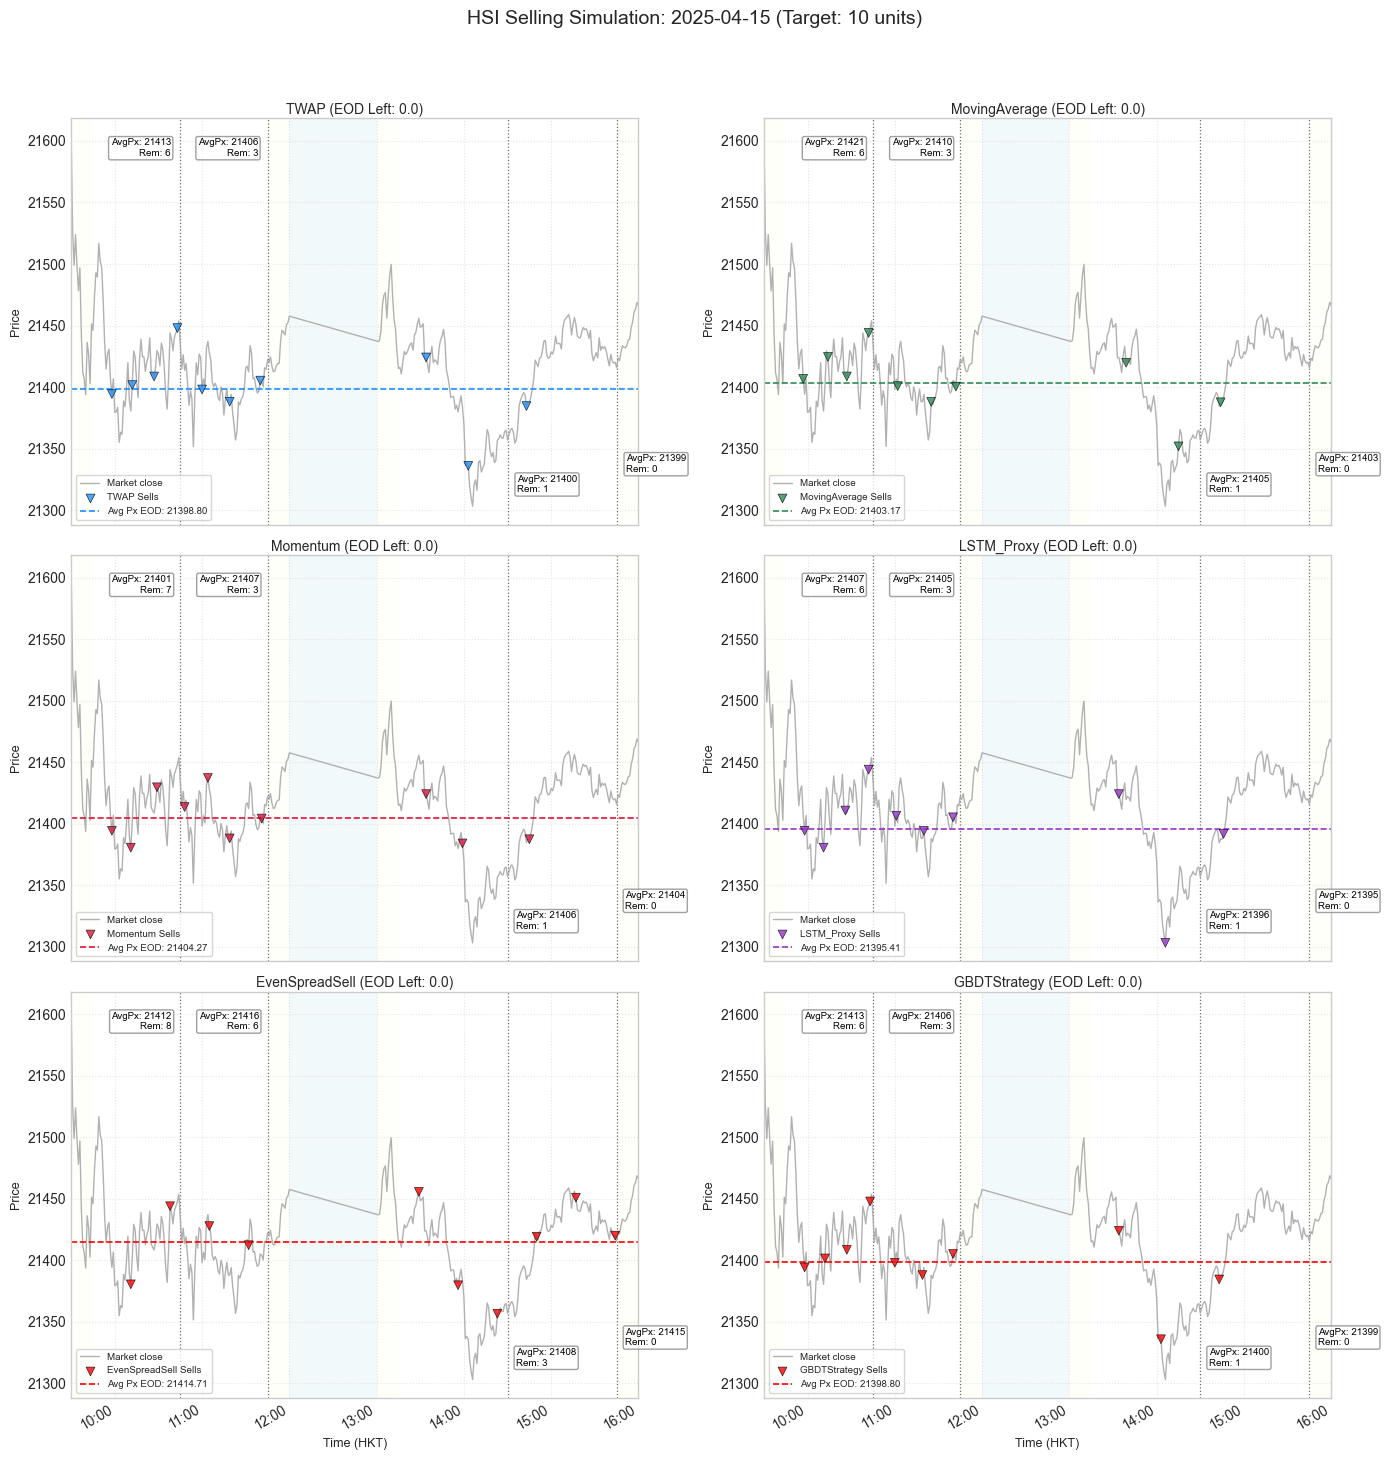


--- Average Daily Performance Across All Simulated Days ---
                Overall Avg Sell Price  Avg Daily Cash  Avg Daily Units Sold  \
Algorithm                                                                      
TWAP                          22542.61       225426.08                 10.00   
GBDTStrategy                  22542.61       225426.08                 10.00   
Momentum                      22542.04       225420.41                 10.00   
MovingAverage                 22541.83       225418.34                 10.00   
EvenSpreadSell                22541.32       225413.19                 10.00   
LSTM_Proxy                    22540.03       225400.34                 10.00   

                Avg Daily Return vs Arrival  Avg Daily Sharpe  \
Algorithm                                                       
TWAP                                  30.02              0.50   
GBDTStrategy                          30.02              0.50   
Momentum                              

In [15]:
# --- 5. Main Simulation Orchestration ---
def run_simulation(full_price_data, featured_data_full):

    if full_price_data.empty or len(full_price_data) < 60: # Ensure some data
        print("Insufficient data loaded. Exiting simulation.")
        return
    
    plt.style.use('seaborn-v0_8-whitegrid')
    print(f"Loaded {len(full_price_data)} HSI data points from {full_price_data.index.min()} to {full_price_data.index.max()}")
    
    all_unique_dates_ts = sorted(list(featured_data_full.index.normalize().unique()))
    
    try:
        detailed_test_date_ts = pd.to_datetime(DETAILED_TEST_DAY_STR).normalize()
    except ValueError:
        print(f"Error: DETAILED_TEST_DAY_STR '{DETAILED_TEST_DAY_STR}' is not a valid date format.")
        if all_unique_dates_ts:
            detailed_test_date_ts = all_unique_dates_ts[-1]
            print(f"Using fallback test day: {detailed_test_date_ts.strftime('%Y-%m-%d')}")
        else: return 
            
    if detailed_test_date_ts not in all_unique_dates_ts:
        print(f"Warning: DETAILED_TEST_DAY_STR {DETAILED_TEST_DAY_STR} not found in dataset.")
        if all_unique_dates_ts:
            detailed_test_date_ts = all_unique_dates_ts[-1]
            print(f"Using fallback test day: {detailed_test_date_ts.strftime('%Y-%m-%d')}")
        else:
            print("No unique dates in dataset. Cannot proceed.")
            return
            
    other_dates_ts = [d for d in all_unique_dates_ts if d != detailed_test_date_ts]

    if len(other_dates_ts) < 2:
        gbdt_train_dates = other_dates_ts
        gbdt_validation_dates = []
    else:
        validation_split_size = min(0.25, (len(other_dates_ts) -1) / len(other_dates_ts) if len(other_dates_ts)>1 else 0.1)
        if validation_split_size <= 0 :
             gbdt_train_dates = other_dates_ts
             gbdt_validation_dates = []
        else:
             gbdt_train_dates, gbdt_validation_dates = train_test_split(other_dates_ts, test_size=validation_split_size, random_state=42, shuffle=True)

    trained_gbdt_model = train_evaluate_gbdt_model(featured_data_full, gbdt_train_dates, gbdt_validation_dates)
    
    algorithms = {
        "TWAP": lambda cf, ul, sl: twap_logic(cf, ul, sl),
        "MovingAverage": lambda cf, ul, sl: moving_average_logic(cf, ul, sl, aggression=0.3),
        "Momentum": lambda cf, ul, sl: momentum_logic(cf, ul, sl, aggression=0.3, roc_threshold=0.02),
        "LSTM_Proxy": lambda cf, ul, sl: lstm_proxy_logic(cf, ul, sl, aggression=0.3),
        "EvenSpreadSell": lambda cf, ul, sl, stp: even_spread_one_unit_logic(cf, ul, sl, stp)
    }
    if trained_gbdt_model:
        algorithms["GBDTStrategy"] = lambda cf, ul, sl, model: gbdt_strategy_logic(cf, ul, sl, model, aggression=0.3)

    all_daily_simulation_results = []
    # TOTAL_UNITS_TO_SELL_PER_DAY needs to be defined, e.g.,
    # TOTAL_UNITS_TO_SELL_PER_DAY = 100
    # DETAILED_TEST_DAY_STR should also be defined, e.g.,
    # DETAILED_TEST_DAY_STR = '2025-04-15'


    print(f"\n--- Running Daily Simulations (Target: Sell {TOTAL_UNITS_TO_SELL_PER_DAY} units/day) ---")
    for day_ts in all_unique_dates_ts:
        current_day_full_data = featured_data_full[featured_data_full.index.normalize() == day_ts]
        if current_day_full_data.empty:
            continue

        tradeable_today_featured_data = get_tradeable_data(current_day_full_data)
        
        # --- MODIFICATION FOR PLOTTING ---
        trades_for_detailed_plot_on_this_day = {} # Collect trades for each algo on this day if it's the detailed test day
        # --- END MODIFICATION ---

        if tradeable_today_featured_data.empty:
            # ... (your existing logic for no tradeable minutes) ...
            for algo_name_key in algorithms.keys():
                 all_daily_simulation_results.append({
                    "Date": day_ts.strftime('%Y-%m-%d'), "Algorithm": algo_name_key,
                    "Total Cash": 0, "Avg Sell Price": 0, "Units Sold": 0, 
                    "Return vs Arrival": 0, "StdDev Prices": 0, "Sharpe": 0, "Trades": 0
                })
            continue # Skip to next day if no tradeable data

        arrival_price_today = tradeable_today_featured_data['close'].iloc[0]

        for name, logic_func_lambda in algorithms.items():
            trades_df_today, total_cash_today = execute_trades(
                tradeable_today_featured_data, TOTAL_UNITS_TO_SELL_PER_DAY, 
                logic_func_lambda, name, 
                gbdt_model=trained_gbdt_model if name == "GBDT_Strategy" else None
            )
            
            # --- MODIFICATION FOR PLOTTING ---
            if day_ts == detailed_test_date_ts:
                trades_for_detailed_plot_on_this_day[name] = trades_df_today
            # --- END MODIFICATION ---
            
            # ... (your existing result calculation logic) ...
            total_units_sold_today = trades_df_today['units_sold'].sum() if not trades_df_today.empty else 0
            avg_sell_price_today = 0; weighted_std_dev_sell_prices_today = 0
            
            if total_units_sold_today > 1e-6:
                avg_sell_price_today = total_cash_today / total_units_sold_today
                if len(trades_df_today) > 1:
                    weighted_std_dev_sell_prices_today = np.sqrt(np.average((trades_df_today['close'] - avg_sell_price_today)**2, weights=trades_df_today['units_sold']))
            
            effective_return_vs_arrival_today = avg_sell_price_today - arrival_price_today if avg_sell_price_today > 0 else 0.0
            sharpe_ratio_today = 0.0
            if weighted_std_dev_sell_prices_today > 1e-6 : sharpe_ratio_today = effective_return_vs_arrival_today / weighted_std_dev_sell_prices_today
            elif effective_return_vs_arrival_today > 1e-9 : sharpe_ratio_today = np.inf
            elif effective_return_vs_arrival_today < -1e-9 : sharpe_ratio_today = -np.inf
            
            all_daily_simulation_results.append({
                "Date": day_ts.strftime('%Y-%m-%d'), "Algorithm": name,
                "Total Cash": total_cash_today, "Avg Sell Price": avg_sell_price_today,
                "Units Sold": total_units_sold_today, "Return vs Arrival": effective_return_vs_arrival_today,
                "StdDev Prices": weighted_std_dev_sell_prices_today, "Sharpe": sharpe_ratio_today,
                "Trades": len(trades_df_today)
            })


        # --- MODIFICATION FOR PLOTTING ---
        # After processing all algorithms for the day, check if it's the detailed test day to plot
        if day_ts == detailed_test_date_ts and trades_for_detailed_plot_on_this_day:
            print(f"\nPlotting detailed simulation for all strategies on {day_ts.strftime('%Y-%m-%d')}")
            plot_detailed_day_simulation(
                current_day_full_data,                      # Full HSI data for the day (1-min res)
                trades_for_detailed_plot_on_this_day,       # Dict of trades_df for each algo
                day_ts.date(),                              # The date object for titles
                TOTAL_UNITS_TO_SELL_PER_DAY                 # Target units for the day
            )
        # --- END MODIFICATION ---

    # ... (your existing summary result printing logic) ...
    if not all_daily_simulation_results:
        print("No simulation results to display.")
        return

    results_df = pd.DataFrame(all_daily_simulation_results)
    results_df['Sharpe'] = results_df['Sharpe'].replace([np.inf, -np.inf], np.nan) 

    print("\n--- Average Daily Performance Across All Simulated Days ---")
    summary_stats = []
    for algo in results_df['Algorithm'].unique():
        algo_df = results_df[results_df['Algorithm'] == algo]
        total_cash_algo = algo_df['Total Cash'].sum()
        total_units_algo = algo_df['Units Sold'].sum()
        
        overall_avg_sell_price = total_cash_algo / total_units_algo if total_units_algo > 0 else 0
        # Filter out days with zero units sold for calculating average return and sharpe if they are per-unit metrics
        valid_trade_days = algo_df[algo_df['Units Sold'] > 0]
        avg_daily_return_vs_arrival = valid_trade_days['Return vs Arrival'].mean() if not valid_trade_days.empty else 0
        avg_daily_sharpe = valid_trade_days['Sharpe'].mean() if not valid_trade_days.empty else 0
        avg_daily_trades = algo_df['Trades'].mean()

        summary_stats.append({
            "Algorithm": algo,
            "Overall Avg Sell Price": overall_avg_sell_price,
            "Avg Daily Cash": algo_df['Total Cash'].mean(),
            "Avg Daily Units Sold": algo_df['Units Sold'].mean(),
            "Avg Daily Return vs Arrival": avg_daily_return_vs_arrival,
            "Avg Daily Sharpe": avg_daily_sharpe, 
            "Avg Daily Trades": avg_daily_trades,
            "Total Days Simulated": algo_df['Date'].nunique()
        })
    
    summary_df = pd.DataFrame(summary_stats).set_index("Algorithm").sort_values(by="Overall Avg Sell Price", ascending=False)
    pd.set_option('display.float_format', '{:.2f}'.format) 
    print(summary_df)

run_simulation(hsi_df, featured_data_full)